In [1]:
import torch
import yaml
import argparse
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import exlib
import math
import torch.nn.functional as F

from datasets import load_dataset
from collections import namedtuple
from exlib.datasets.pretrain import setup_model_config, get_dataset, get_dataset, setup_model_config
from exlib.datasets.dataset_preprocess_raw import create_train_dataloader_raw, create_test_dataloader_raw, create_test_dataloader
from exlib.datasets.informer_models import InformerConfig, InformerForSequenceClassification
from exlib.datasets.supernova import plot_data_by_wavelength, baseline, plot_flux_time_with_error_bars_group, perform_linear_regression_vectorized, threshold_f_vectorized
from tqdm.auto import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/opt/conda/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


### Dataset

In [2]:
# load dataset
dataset = load_dataset("BrachioLab/supernova-timeseries")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

### Model predictions

In [3]:
# load model
model = InformerForSequenceClassification.from_pretrained("BrachioLab/supernova-classification")
model = model.to(device)
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader(
    config=config,
    dataset=test_dataset,
    batch_size=5,
    compute_loss=True
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub-0.23.2-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


num labels: 14
Using Fourier PE
classifier dropout: 0.2
original dataset size: 792
remove nans dataset size: 792


In [4]:
with torch.no_grad():
    y_true = []
    y_pred = []
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        outputs = model(**batch)
        y_true.extend(batch['labels'].cpu().numpy())
        y_pred.extend(torch.argmax(outputs.logits, dim=2).squeeze().cpu().numpy())
# model prediction
print(f"accuracy: {sum([1 for i, j in zip(y_true, y_pred) if i == j]) / len(y_true)}")

  0%|          | 0/159 [00:00<?, ?it/s]

accuracy: 0.7967171717171717


### Dataset Samples

In [5]:
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader_raw(
    config=config,
    dataset=test_dataset,
    batch_size=25,
    compute_loss=True
)

original dataset size: 792
remove nans dataset size: 792


  0%|          | 0/32 [00:00<?, ?it/s]

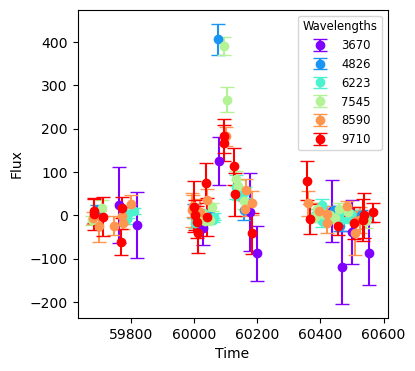

In [6]:
# dataset sample
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 12:
            for j in range(len(valid_time_values_batch)):
                if j == 7:
                    plot_data_by_wavelength(valid_time_values_batch[j], valid_flux_values_batch[j], 
                                                valid_flux_error_values_batch[j], valid_wavelength_values_batch[j],
                                                'Flux vs. Time with Error Bars by Wavelength', bi, j)

### Alignment score without ground truth

In [7]:
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader_raw(
    config=config,
    dataset=test_dataset,
    batch_size=25,
    compute_loss=True
)

original dataset size: 792
remove nans dataset size: 792


In [8]:
def get_fix_scores(test_dataloader, baseline, device, eps=1, min_len=3, window_size=50, step_size=25):
    fix_list = []
    with torch.no_grad():
        for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
            times_wv_column = batch['past_time_features']
            target_column = batch['past_values']
            x_column = torch.cat((times_wv_column, target_column), dim=2)
            time_values, wavelength_values, flux_values, flux_error_values = x_column[:, :, 0], x_column[:, :, 1], x_column[:, :, 2], x_column[:, :, 3]

            diff_time = torch.diff(time_values, dim=1)
            non_increasing = diff_time <= 0
            padded_non_increasing = torch.nn.functional.pad(non_increasing, (1, 0), "constant", False)
            int_non_increasing = padded_non_increasing.int()
            valid_lengths = torch.argmax(int_non_increasing, dim=1)
            valid_lengths = torch.where(valid_lengths == 0, time_values.size(1), valid_lengths)

            valid_time_values_batch, valid_wavelength_values_batch, valid_flux_values_batch, valid_flux_error_values_batch = zip(*[
                (time_values[i, :l].clone().detach(), wavelength_values[i, :l].clone().detach(), flux_values[i, :l].clone().detach(), flux_error_values[i, :l].clone().detach()) for i, l in enumerate(valid_lengths)])

            pred_groups_batch = [baseline(l.item()) for l in valid_lengths]

            for j in range(len(valid_time_values_batch)):
                times, fluxes, errors, wavelengths = map(lambda x: x[j], [valid_time_values_batch, valid_flux_values_batch, valid_flux_error_values_batch, valid_wavelength_values_batch])
                unique_wavelengths = sorted(set(wavelengths.cpu().numpy()))
                num_unique_wavelengths = len(unique_wavelengths)

                time_wv = {w: [] for w in unique_wavelengths}
                flux_wv = {w: [] for w in unique_wavelengths}
                error_wv = {w: [] for w in unique_wavelengths}

                for time, flux, error, wavelength in zip(times.tolist(), fluxes.tolist(), errors.tolist(), wavelengths.tolist()):
                    time_wv[wavelength].append(time)
                    flux_wv[wavelength].append(flux)
                    error_wv[wavelength].append(error)

                color_map = plt.get_cmap('rainbow')
                colors = color_map(np.linspace(0, 1, len(unique_wavelengths)))
                wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}
                
                alignment_scores_all = []
                for k in range(len(pred_groups_batch[j])):
                    group_time = torch.tensor([times[i] for i, value in enumerate(pred_groups_batch[j][k]) if value == 1])
                    group_slope = []
                    group_intercept = []
                    group_threshold = []
                    group_p = []
                    group_f = []

                    chunk_time = torch.arange(group_time[0], group_time[-1], step_size).unsqueeze(1)
                    chunk_time = torch.cat([chunk_time, chunk_time + window_size], dim=1)
                    chunk_time = torch.clamp(chunk_time, max = group_time[-1])
                    
                    if len(chunk_time) > 0:
                        for m in range(num_unique_wavelengths):
                            wavelength = unique_wavelengths[m]
                            crop_time_wv = torch.tensor(time_wv[wavelength])
                            mask = torch.isin(crop_time_wv, group_time)
                            crop_time_wv = crop_time_wv[mask]
                            crop_flux_wv = torch.tensor(flux_wv[wavelength])[mask]
                            crop_error_wv = torch.tensor(error_wv[wavelength])[mask]
                            
                            slope, intercept = perform_linear_regression_vectorized(crop_time_wv.float(), crop_flux_wv.float())
                            group_slope.append(slope)
                            group_intercept.append(intercept)
                            threshold = threshold_f_vectorized(eps, crop_error_wv.float(), crop_time_wv.float())
                            group_threshold.append(threshold)
    
                            predicted_flux = slope * crop_time_wv + intercept
                            correct_preds = (predicted_flux >= crop_flux_wv - (eps * crop_error_wv)) & (predicted_flux <= crop_flux_wv + (eps * crop_error_wv))
                            perc = correct_preds.sum().item() / len(crop_time_wv) if len(crop_time_wv) > 0 else 0
                            group_f.append(perc)
                            
                            p_in = 0
                            for start, end in chunk_time:
                                chunk_mask = (crop_time_wv >= start) & (crop_time_wv <= end)
                                if torch.any(chunk_mask):
                                    p_in += 1
                            group_p.append(p_in / len(chunk_time))
                        
                        group_lc = [p * f for p, f in zip(group_p, group_f)]
                        if all(slope <= threshold for slope, threshold in zip(group_slope, group_threshold)):
                            max_lc = max(group_lc)
                        else:
                            max_lc = max(lc for slope, lc, threshold in zip(group_slope, group_lc, group_threshold) if slope > threshold)
                        alignment_scores_all.append(max_lc)
                        
                pred_groups_batch_j = torch.tensor(pred_groups_batch[j])
                alignment_scores_all = torch.tensor(alignment_scores_all)
                group_alignment = torch.zeros(pred_groups_batch_j.shape[1])

                if alignment_scores_all.shape[0] == pred_groups_batch_j.shape[0]:
                    for idx in range(pred_groups_batch_j.shape[1]):
                        mask = pred_groups_batch_j[:, idx].bool()
                        if mask.any() and mask.shape[0] == alignment_scores_all.shape[0]:
                            selected_scores = alignment_scores_all[mask]
                            if selected_scores.numel() > 0:
                                group_alignment[idx] = selected_scores.mean() 
                fix_list.append(group_alignment.mean().item())
            fix_tensor = torch.tensor(fix_list)
            
    return fix_tensor.float().mean().item()

In [9]:
fix_score = get_fix_scores(test_dataloader, baseline, device)
print("FIX Score:", fix_score)

  0%|          | 0/32 [00:00<?, ?it/s]

FIX Score: 0.3920414447784424
